In [1]:
!ls

codes  tf-gpu-env  torch-gpu-env


In [2]:
import os

PATH_CODE = "/mnt/c/Users/User/Documents/codes/DL/deeplearning_codes"
PATH_DATASET = "/mnt/c/Users/User/Documents/DATASETS/human_activities/WISDM_ar_v1.1/"

os.chdir(PATH_CODE)
!ls

MNIST_Ejm_GPU.ipynb	  test_camera.ipynb
README.md		  test_show_video.py
V_1.mp4			  test_show_video_model.py
convert_model_to_h.ipynb  tf_gpu_test1.ipynb
images			  tutorial1_torch.ipynb
lstm1.ipynb		  violence-detection-classifier.ipynb
modelo.h		  violence_detection_classifier2.ipynb
modelo.tflite		  violence_detection_model.pth
output_video.gif	  violence_detection_model_state_dict.pth
output_video.mp4


## Leer Dataset

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv(PATH_DATASET+"WISDM_ar_v1.1_raw.csv", names=['usuario', 'actividad', 'timestamp', 'x', 'y', 'z'])
df.head()

,usuario,actividad,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


## Crear modelo LSTM

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

2024-11-07 23:12:13.075031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731039133.084255    7440 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731039133.087130    7440 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 23:12:13.096897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Eliminar valores nulos
df.dropna(inplace=True)

# Limpiar y convertir la columna 'z'
#df['z'] = df['z'].str.replace(';', '').astype(float)

# Filtrar registros con timestamp válido
df = df[df['timestamp'] != 0]

# Ordenar datos por usuario y timestamp
df.sort_values(by=['usuario', 'timestamp'], inplace=True)


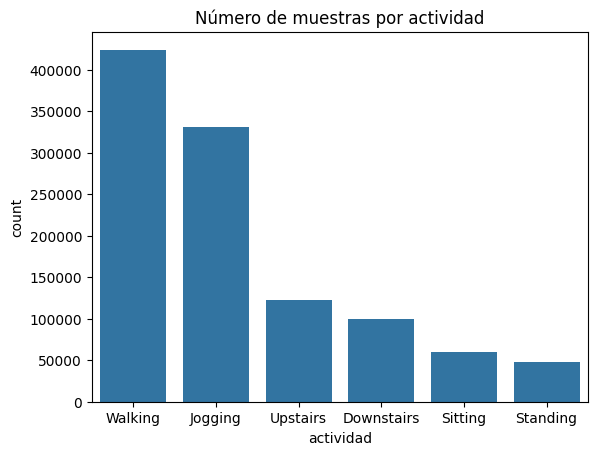

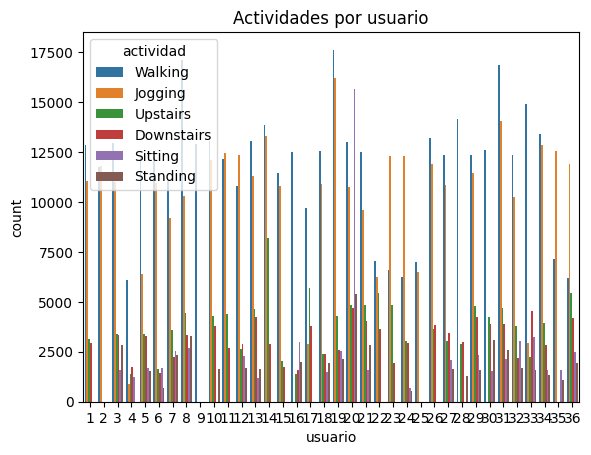

In [7]:
# Distribución de actividades
sns.countplot(x='actividad', data=df)
plt.title('Número de muestras por actividad')
plt.show()

# Distribución de actividades por usuario
sns.countplot(x='usuario', hue='actividad', data=df)
plt.title('Actividades por usuario')
plt.show()

In [8]:
random_seed = 42   
n_time_steps = 50 
n_features = 3 
step = 10 
n_classes = 6 
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015
segments = []
labels = []

for i in range(0,  df.shape[0]- n_time_steps, step):  
    xs = df['x'].values[i: i + 50]
    ys = df['y'].values[i: i + 50]
    zs = df['z'].values[i: i + 50]

    #label = stats.mode(df['actividad'][i: i + 50])[0][0]
    label = np.unique(df['actividad'][i: i + n_time_steps], return_counts=True)[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

#reshape the segments which is (list of arrays) to a list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

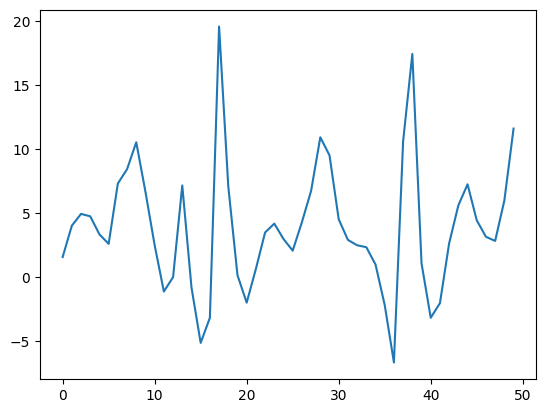

In [29]:
plt.plot(segments[1][0])

In [9]:
# Definir parámetros
#n_tiempo_pasos = 50
#n_caracteristicas = 3
#paso = 10
#n_clases = 6

# Segmentación de datos
#segmentos = []
#etiquetas = []
#for i in range(0, len(df) - n_tiempo_pasos, paso):
#    xs = df['x'].values[i: i + n_tiempo_pasos]
#    ys = df['y'].values[i: i + n_tiempo_pasos]
#    zs = df['z'].values[i: i + n_tiempo_pasos]
#    etiqueta = np.unique(df['actividad'][i: i + n_tiempo_pasos], return_counts=True)[0][0]
#    segmentos.append([xs, ys, zs])
#    etiquetas.append(etiqueta)

# Convertir a arrays numpy
#segmentos = np.asarray(segmentos, dtype=np.float32).reshape(-1, n_tiempo_pasos, n_caracteristicas)
#etiquetas = pd.get_dummies(etiquetas).values


In [10]:
#X_train, X_test, y_train, y_test = train_test_split(segmentos, etiquetas, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)



In [11]:
# Definir el modelo
#modelo = Sequential()
#modelo.add(LSTM(128, input_shape=(n_tiempo_pasos, n_caracteristicas)))
#modelo.add(Dropout(0.5))
#modelo.add(Dense(n_clases, activation='softmax'))

# Compilar el modelo
#modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
#historia = modelo.fit(X_train, y_train, epochs=50, batch_size=1024, validation_split=0.2, verbose=1)

from tensorflow.keras.optimizers import Adam

model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5)) 
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

I0000 00:00:1731039141.586804    7440 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/moises/tf-gpu-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,230 (297.77 KB)

 Trainable params: 76,230 (297.77 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)


Epoch 1/50


I0000 00:00:1731039143.204995    7516 cuda_dnn.cc:529] Loaded cuDNN version 90300


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.3307 - loss: 1.6700 - val_accuracy: 0.6038 - val_loss: 1.3789
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6129 - loss: 1.2257 - val_accuracy: 0.7158 - val_loss: 0.7801
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7364 - loss: 0.7789 - val_accuracy: 0.7783 - val_loss: 0.6672
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7758 - loss: 0.6789 - val_accuracy: 0.7933 - val_loss: 0.6090
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7900 - loss: 0.6258 - val_accuracy: 0.8061 - val_loss: 0.5696
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8032 - loss: 0.5868 - val_accuracy: 0.8134 - val_loss: 0.5447
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8073 - loss: 0.5567 - val_accuracy: 0.8165 - val_loss: 0.5225
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8167 - loss: 0.5295 - val_accuracy: 0.8184 - val_loss: 0.

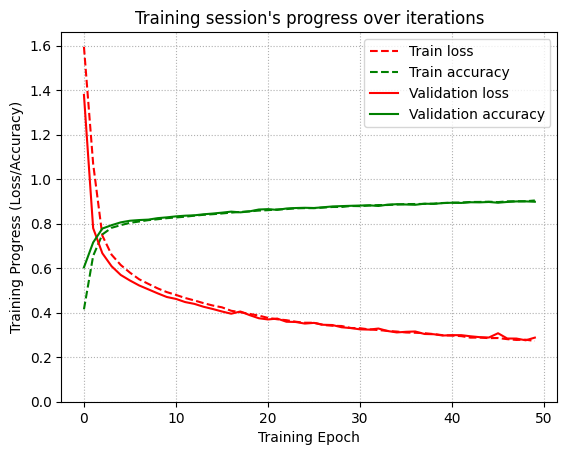

In [17]:
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.grid(ls=":")
plt.show()

In [15]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9022 - loss: 0.2811
Test Accuracy : 0.9019210338592529
Test Loss : 0.2787322998046875


679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


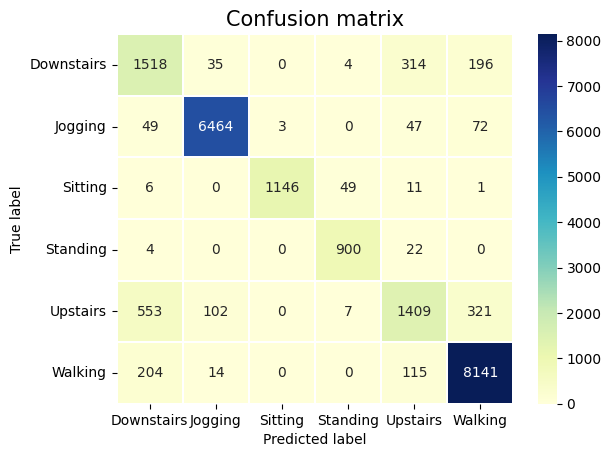

In [19]:
from sklearn import metrics


predictions = model.predict(X_test)
class_labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
# Evaluar en datos de prueba
perdida, precision = model.evaluate(X_test, y_test, verbose=1)
print(f'Precisión en datos de prueba: {precision * 100:.2f}%')


679/679 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9025 - loss: 0.2809
Precisión en datos de prueba: 90.19%


In [21]:
model.save('model.h5')

In [24]:
model.save('lstm_model.keras')